<a href="https://colab.research.google.com/github/KJohnmar/INL-OBELIX-2026/blob/main/sp3-model/square-lattice/sp3-model-SquareLattice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/KJohnmar/INL-OBELIX-2026/blob/main/sp3-model/square-lattice/sp3-model-SquareLattice.ipynb)

$\def\bra#1{\mathinner{\langle{#1}|}}
\def\ket#1{\mathinner{|{#1}\rangle}}
\def\braket#1#2{\mathinner{\langle{#1}|{#2}\rangle}}$

## __Environment Setup For Computational Physics and Data Visualization__

In [ ]:
%%capture --no-display
!pip install -i https://test.pypi.org/simple/ pybinding

In [ ]:
%%capture --no-display
!apt-get install texlive texlive-latex-extra texlive-fonts-recommended dvipng cm-super

In [ ]:
# ==============================================================================
# 1. Environment Control & Warning Management
import warnings
warnings.filterwarnings("ignore")
# ==============================================================================
# 2. System & OS Utilities
import os
import os.path
import logging
import re
import itertools
# ==============================================================================
# 3. Numerical Computing & Data Manipulation (The "SciPy Stack")
import numpy as np
import pandas as pd
import math
# ==============================================================================
# 4. Computational Physics & Scientific Calculations
import pybinding as pb
from scipy.interpolate import griddata
import scipy.integrate as itg
# ==============================================================================
# 5. Data Visualization & Styling
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from matplotlib import rc
import matplotlib.patheffects as path_effects
from matplotlib.collections import LineCollection
import matplotlib.image as mpimg
# ==============================================================================
# 6. Advanced Plotting Components
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.offsetbox import (
    AnchoredOffsetbox, AuxTransformBox, DrawingArea, TextArea, VPacker)
from matplotlib import transforms
# ==============================================================================
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Configure LaTeX to use Times New Roman.
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "mathtext.fontset": "custom",
    "mathtext.rm": "Times New Roman",
    "mathtext.it": "Times New Roman:italic",
    "mathtext.bf": "Times New Roman:bold",
    "text.latex.preamble": r"""
        \usepackage{amsmath}
        \usepackage{xfrac}
    """
})

## __Project Goal:__ $sp³$-model using Chebyshev Polynomials (Quantum-Kite)

## __$sp³$-model in Square Lattice__
<font color="red">

1. [x] __Tight-Binding Formalism__
    - [x] The Basis Set
    - [x] The Tight-Binding Hamiltonian
2. [x] __Spin-Orbit Coupling__
    - [x] The Expanded Basis
    - [x] The SOC Hamiltonian
3. [x] __Slater-Koster Approximation__
    - [x] Hamiltoniam Matrix Elements
    - [x] Band Structure (plot)
        - [x] Analytically
        - [x] Diagonalization using Pybinding
    - [_] Density of States (Chebyshev Polynomials)
4. [_] __Hall Conductiviy__
    - [_] Theoretical Background
    - [_] Implementation Steps
    - [_] Hall Conductivity (Chebyshev Polynomials)

</font>

<h1 align="center"></h1>

___
# <center>**$sp^3$-model in Square Lattice**</center>
___

The $sp^{3}$ model considers four atomic orbitals per site:
- One $s$-orbital ($\ket{s}$)
- Three $p$-orbitals ($\ket{p_x}$, $\ket{p_y}$, $\ket{p_z}$)

On a 2D square lattice, we typically focus on the orbital in the $xy$-plane, though $\ket{p_z}$ can be included as a decoupled or weakly coupled band.

## __1. Tight-Binding Formalism__

### __A. <u>The Basis Set</u>__

The Bloch basis functions are:
$$
\ket{\phi_m, \mathbf{k}} = \dfrac{1}{\sqrt{N}}\sum_{{\rm R}_i}e^{i{\rm k}⋅{\rm R}_i}\ket{\phi_m, \mathbf{R}_i}
$$
where $m ∈ {s,p_x​,p_y​,p_z​}$

At each lattice site $\mathbf{R}_{i}$, the basis is defined by the state vector:
$$
\Psi_{\mathbf{k}} =
\begin{pmatrix}
    \ket{s, \mathbf{k}} \\
    \ket{p_x, \mathbf{k}} \\
    \ket{p_y, \mathbf{k}} \\
    \ket{p_z, \mathbf{k}}
\end{pmatrix}
$$

### __B. <u>The Tight-Binding Hamiltonian</u>__

The Hamiltonian is an $4\times4$ matrix $H(\mathbf{k})$. It consists of __on-site energies__ $(E_s​,E_p​)$ and __hopping integrals__ between nearest neighbors.

The general form of the matrix is:
$$
H(\mathbf{k}) =
\begin{pmatrix}
    H_{ss}    & H_{sp_x}    & H_{sp_y}    & 0          \\
    H_{p_xs}  & H_{p_xp_x}  & 0           & 0          \\
    H_{p_ys}  & 0           & H_{p_yp_y}  & 0          \\
    0         & 0           & 0           & H_{p_zp_z} \\
\end{pmatrix}
$$
___

## __2. Spin-Orbit Coupling__

To include __Spin-Orbit Coupling (SOC)__ in your $sp^3$ tight-binding model, you must double the size of your basis to account for the two possible spin states (up $\uparrow$ and down $\downarrow$) of each orbital.

### __A. <u>The Expanded Basis</u>__

The new basis set contains 8 states (4 orbitals $\times$ 2 spins):
$$
\Psi_{\mathbf{k}} =
\begin{pmatrix}
    \ket{s, \uparrow} & \ket{p_x, \uparrow} & \ket{p_y, \uparrow}, \ket{p_z, \uparrow} &
    \ket{s, \downarrow} & \ket{p_x, \downarrow} & \ket{p_y, \downarrow} & \ket{p_z, \downarrow}
\end{pmatrix}
^T
$$
The total Hamiltonian becomes an $8\times 8$ matrix:
$$
H_{\rm total}​(\mathbf{k}) = H_0​(\mathbf{k})\otimes \mathbb{I}_2​ + H_{\rm SOC}​  
$$
- $H_0​(\mathbf{k})$ is your original $4\times 4$ kinetic Hamiltonian.

- $\otimes \mathbb{I}_2$ places the kinetic terms in both the spin-up and spin-down blocks.

- $H_{\rm SOC}$ is the on-site spin-orbit interaction

### __B. <u>The SOC Hamiltonian</u>__

The spin-orbital interaction is modeled by the operators
$$H_{\rm SOC} = \dfrac{2\alpha_{\rm so}}{\hbar^2} {\rm L} \cdot {\rm S}$$
where $\alpha_{\rm so}$ is the SOC parameter. The ${\rm L}$ (${\rm S}$) is the orbital (spin) angular momentum operator nuclei.
- Since $s$-orbitals have $L=0$, they do not contribute to SOC. Physically, an electron in an s-state has no "looping" motion around the nucleus, so it doesn't create the orbital magnetic moment needed to interact with its spin.

- $p$-orbitals ($L=1$): These have a clear directional "shape" and angular momentum. The three $p$-orbitals ($p_x$​, $p_y$​, $p_z$​) can be combined into states like $\ket{m_l = \pm 1}$ which represent clear rotations. Because they have $L=1$, the ${\rm L} \cdot {\rm S}$ term is non-zero and causes the energy levels to split. For $p$-orbitals, ${\rm L}=(L_x,L_y,L_z)$ becomes:
$$L_x = \hbar
\begin{pmatrix}
    0  & 0  & 0  \\
    0  & 0  & -i \\
    0  & i  & 0  \\
\end{pmatrix} , \;\;\;
L_y = \hbar
\begin{pmatrix}
    0  & 0  & i  \\
    0  & 0  & 0  \\
    -i & 0  & 0  \\
\end{pmatrix} , \;\;\;
L_z = \hbar
\begin{pmatrix}
    0  & -i & 0  \\
    i  & 0  & 0  \\
    0  & 0  & 0  \\
\end{pmatrix} .
$$

- The spin angular momentum operators are represented by the Pauli matrices within each orbital, ${\rm S}=(S_x,S_y,S_z)$:
$$
S_x = \dfrac{\hbar}{2}\sigma_x , \;\;\; S_y = \dfrac{\hbar}{2}\sigma_y , \;\;\; S_z = \dfrac{\hbar}{2}\sigma_z .
$$

The interaction only occurs within the $p$-orbital manifold. In the basis $\{ \ket{p_x, \uparrow}, \ket{p_y, \uparrow}, \ket{p_z, \uparrow}, \ket{p_x, \downarrow}, \ket{p_y, \downarrow}, \ket{p_z, \downarrow}\}$, the matrix is:
$$
H_{\rm SOC} = \alpha_{\rm so}
\begin{pmatrix}
    0  & -i & 0  & 0  & 0  & 1  \\
    i  & 0  & 0  & 0  & 0  & -i \\
    0  & 0  & 0  & -1 & i  & 0  \\
    0  & 0  & -1 & 0  & i  & 0  \\
    0  & 0  & -i & -i & 0  & 0  \\
    1  & i  & 0  & 0  & 0  & 0  \\
\end{pmatrix}
$$


##### __Physical Impact on the Square Lattice__

- __Lifting Degeneracies:__ At the $\Gamma$-point ($\mathbf{k}$), the $p$-bands which were previously degenerate will split.

- __Band Inversion:__ In some materials (like topological insulators), a strong $\alpha_{\rm so}$ can push a $p$-band below an $s$-band, changing the topology of the system.

- __Rashba Splitting:__ If your square lattice lacks inversion symmetry (e.g., it is on a substrate), SOC will cause the bands to shift in $k$-space based on their spin.
___


## __3. Slater-Koster Approximation__

Let $a$ be the lattice constant and $\mathbf{k}=(kx​,ky​)$. Using the __Slater-Koster parameters__ ($V_{ss\sigma}$​, $V_{sp\sigma}$​, $V_{pp\sigma}$​, $V_{pp\pi}$), the elements for a square lattice are:
    
- __Diagonal (On-site + Hopping)__

    - **$s$-orbital:** $H_{ss} = E_s ​+ 2V_{ss\sigma}​(\cos{k_x​a} + \cos{k_y​a})$

    - **$p_x$​-orbital:** $H_{p_xp_x}​​ = E_p​ + 2V_{pp\sigma}\cos{k_x​a} + 2V_{pp\pi}\cos{k_y​a}$

    - **$p_y$​-orbital:** $H_{p_yp_y} = E_p ​+ 2V_{pp\pi}\cos{k_x​a} + 2V_{pp\sigma}​\cos{k_y​a}$

    - **$p_z$​-orbital:** $H_{p_zp_z} ​= E_p​ + 2V_{pp\pi}​(\cos{k_x​a} + \cos{k_y​a})$

- __Off-Diagonal (Coupling)__

    - **$s$ and $p$ coupling:** $H_{sp_x} ​=2iV_{sp\sigma}​\sin{k_x​a}$ and $H_{sp_y}​​=2iV_{sp\sigma}​\sin{k_ya}$

    - **$p$ and $p$ coupling:** $H_{p_xp_y}​​ = 0$ (for nearest neighbors on a simple square lattice, the symmetry of $p_x$​ and $p_y$​ results in zero overlap along the axes).
___

### __B. Band Structure *(Plot)*__

Set the parameters for the $sp^3$ model

In [ ]:
"""
******** Parameter dictionary for electronic band models ***********
    a       : Lattice parameter (in nm)
    eps1    : s-orbital energy
    eps2    : p-orbital energy
    tss     : s-s orbital hopping
    tpsigma : p-p sigma hopping
    tppi    : p-p pi hopping
    tsp     : s-p hopping
    lsoc    : Spin-orbit coupling (SOC) strength
"""

"""
Each orbital will be treated as a separate sublattice
"""
_default_sp3 = {
    # ->      [     a,   E_s,   E_px,   E_py,   E_pz,  V_ss_sigma,   V_pp_sigma,   V_pp_pi,   V_sp_sigma,     soc]
    "SP3-Go": [   1.0,   3.2,   -0.5,   -0.5,   -0.5,        -0.5,          0.5,      -0.2,          0.5,     0.1]
}

#### __B.1. Analytically__

In this section, we define the functional form of the Hamiltonian matrix elements. By applying the Bloch theorem to the Slater-Koster integrals, we obtain the k-dependent expressions for the energy bands.

Define the Hamiltonian:
- Without SOC

In [ ]:
def get_H(k, name, t_sp_sigma=None, override_params=None):
    """
    Parameters:
        k               : k-vector
        name            : Material name ("SP3-Go")
        t_sp_sigma      : Effect of s-p orbital coupling
        override_params : Custom parameters
    """
    # Get parameters
    params = _default_sp3.copy()
    if override_params:
        params.update(override_params)

    a, E_s, E_px, E_py, E_pz, V_ss_sigma, V_pp_sigma, V_pp_pi, V_sp_sigma, soc = params[name]
    if t_sp_sigma: V_sp_sigma = t_sp_sigma   # Overwrite s-p hopping with spin value
    soc = 0.0                                # Overwrite Spin-orbit coupling value
    parameters = [r"$sp^3$-model:  ", a, E_s, E_px, E_py, E_pz, V_ss_sigma, V_pp_sigma, V_pp_pi, V_sp_sigma, soc]

    kx, ky = k

    # Diagonal elements (On-site + nearest neighbor hopping)
    H_ss = E_s  + 2 * V_ss_sigma * (np.cos(kx*a) + np.cos(ky*a))
    H_xx = E_px + 2 * V_pp_sigma * np.cos(kx*a) + 2 * V_pp_pi * np.cos(ky*a)
    H_yy = E_py + 2 * V_pp_sigma * np.cos(ky*a) + 2 * V_pp_pi * np.cos(kx*a)
    H_zz = E_pz + 2 * V_pp_pi * (np.cos(kx*a) + np.cos(ky*a))

    # Off-diagonal elements (s-p coupling)
    # Note: 2j * sin(x) comes from (exp(jkx) - exp(-jkx))
    H_sx = 2j * V_sp_sigma * np.sin(kx*a)
    H_sy = 2j * V_sp_sigma * np.sin(ky*a)

    # Construct 4x4 matrix
    H = np.array([
        [         H_ss, H_sx, H_sy,    0],
        [np.conj(H_sx), H_xx,    0,    0],
        [np.conj(H_sy),    0, H_yy,    0],
        [            0,    0,    0, H_zz]
    ])

    return H, parameters

- With SOC

In [ ]:
def get_H_SOC(k, name, t_sp_sigma=None, lsoc=None, override_params=None):
    """
    Parameters:
        k               : k-vector
        name            : Material name ("SP3-Go")
        t_sp_sigma      : Effect of s-p orbital coupling
        lsoc            : Effect of spin-orbital coupling
        override_params : Custom parameters
    """
    # Get parameters
    params = _default_sp3.copy()
    if override_params:
        params.update(override_params)

    a, E_s, E_px, E_py, E_pz, V_ss_sigma, V_pp_sigma, V_pp_pi, V_sp_sigma, soc = params[name]
    if t_sp_sigma: V_sp_sigma = t_sp_sigma   # Overwrite s-p hopping with spin value
    if lsoc: soc = lsoc                      # Overwrite Spin-orbit coupling value
    parameters = [r"$sp^3$-model:  ", a, E_s, E_px, E_py, E_pz, V_ss_sigma, V_pp_sigma, V_pp_pi, V_sp_sigma, soc]

    kx, ky = k

    # Get the 4x4 spatial part
    H_orbital, *_ = get_H(k, name, V_sp_sigma, override_params)

    # Create 8x8 matrix (Spin up block and Spin down block)
    H_8x8 = np.block([
        [      H_orbital, np.zeros((4,4))],
        [np.zeros((4,4)),       H_orbital]
    ])

    # Define H_SO (p-orbitals only, indices 1,2,3 and 5,6,7)
    # Using the matrix form provided in previous turns
    H_soc = np.zeros((8, 8), dtype=complex)

    # Example for L.S matrix elements (simplified subset)
    #H_soc[1, 2] = -1j * soc
    #H_soc[2, 1] = +1j * soc
    #H_soc[5, 6] = +1j * soc
    #H_soc[6, 5] = -1j * soc

    H_soc[1, 2] = H_soc[2, 7] = H_soc[6, 3] = H_soc[6, 5] = -1j * soc
    H_soc[2, 1] = H_soc[7, 2] = H_soc[3, 6] = H_soc[5, 6] = +1j * soc
    H_soc[1, 7] = H_soc[7, 1] = +1 * soc
    H_soc[3, 5] = H_soc[5, 3] = -1 * soc

    return H_8x8 + H_soc, parameters

Define $k$-path ($\Gamma$ - $\rm X$ - $\rm M$ - $\Gamma$)

In [ ]:
def get_path(name, n_pts, override_params=None):
    """
    Parameters:
        override_params : Custom parameters
    """
    # Get parameters
    params = _default_sp3.copy()
    if override_params:
        params.update(override_params)

    a = params[name][0]

    Gamma_pt = np.array([0, 0])
    X_pt = np.array([np.pi/a, 0])
    M_pt = np.array([np.pi/a, np.pi/a])

    path1 = np.linspace(Gamma_pt, X_pt, n_pts)
    path2 = np.linspace(X_pt, M_pt, n_pts)
    path3 = np.linspace(M_pt, Gamma_pt, n_pts)
    full_path = np.vstack([path1, path2, path3])

    return full_path

Diagonalize at each $k$-point

In [ ]:
name = "SP3-Go"
n_pts = 100        # We have 3 paths, so we have 3*n_pts points in full_path
full_path = get_path(name, n_pts, override_params=None)
# Without SOC
bands = []
for k in full_path:
    H, parameters = get_H(k, name, t_sp_sigma=None, override_params=None)
    eigenvalues = np.linalg.eigvalsh(H)
    bands.append(eigenvalues)

bands = np.array(bands)
# With SOC
bands_soc = []
for k in full_path:
    H, parameters_soc = get_H_SOC(k, name, t_sp_sigma=None, lsoc=None, override_params=None)
    eigenvalues = np.linalg.eigvalsh(H)
    bands_soc.append(eigenvalues)

bands_soc = np.array(bands_soc)

Plotting

In [ ]:
def plot_square_bz(ax):
    a = 1.0
    lim = np.pi / a

    # 1. Desenhar a fronteira da Primeira BZ (Quadrado)
    # Definimos os cantos para fechar o quadrado: (-lim, -lim) -> (lim, -lim) -> (lim, lim) -> (-lim, lim) -> (-lim, -lim)
    bz_x = [-lim, lim, lim, -lim, -lim]
    bz_y = [-lim, -lim, lim, lim, -lim]
    ax.plot(bz_x, bz_y, color="tab:blue", linewidth=2, label="1st BZ Boundary")

    # 2. Definir Pontos de Alta Simetria
    points = {
        r'$\Gamma$': [0, 0],
        r'$X$': [lim, 0],
        r'$M$': [lim, lim]
    }

    # 3. Plotar o Caminho: Gamma -> X -> M -> Gamma
    path = np.array([points[r'$\Gamma$'], points[r'$X$'], points[r'$M$'], points[r'$\Gamma$']])
    ax.plot(path[:,0], path[:,1], color='tab:red', linewidth=3, label='Path', zorder=3)

    # 4. Dispersão e Rótulos
    for label, coord in points.items():
        ax.scatter(*coord, color='black', s=50, zorder=4)
        # Ajuste fino da posição do texto
        ax.text(coord[0] + 0.1, coord[1] - 0.5, label, fontsize=14)

    # Configurações de Eixo
    ax.set_xlabel(r'$k_x$', fontsize=15)
    ax.set_ylabel(r'$k_y$', fontsize=15)
    ax.set_title('First Brillouin Zone (Simple Square 2D)')
    ax.set_aspect('equal')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_xlim(-lim-0.5, lim+0.5)
    ax.set_ylim(-lim-0.5, lim+0.5)

    return ax

In [ ]:
def plot_BandStructure_bands(ax, bands, bands_soc, parameters, parameters_soc):
    lab1 = r"$\alpha_{\rm so} = " + str(parameters[10]) + r"$"
    lab2 = r"$\alpha_{\rm so} = " + str(parameters_soc[10]) + r"$"

    ax.plot(bands[:, 0], color='tab:red', lw=2, label=lab1)
    ax.plot(bands[:, 1], color='tab:red', lw=2)
    ax.plot(bands[:, 2], color='tab:red', lw=2)
    ax.plot(bands[:, 3], color='tab:red', lw=2)

    ax.plot(0.5*bands_soc[:, 0] + 0.5*bands_soc[:, 1], color='tab:blue', lw=2, label=lab2)
    ax.plot(0.5*bands_soc[:, 2] + 0.5*bands_soc[:, 3], color='tab:blue', lw=2)
    ax.plot(0.5*bands_soc[:, 5] + 0.5*bands_soc[:, 5], color='tab:blue', lw=2)
    ax.plot(0.5*bands_soc[:, 6] + 0.5*bands_soc[:, 7], color='tab:blue', lw=2)

    ax.legend(fontsize=16, loc='best', frameon=False, handlelength=1.0)
    ax.axvline(n_pts, color='tab:gray', linestyle='--', lw=1)
    ax.axvline(2*n_pts, color='tab:gray', linestyle='--', lw=1)
    ticks = [0, n_pts, 2*n_pts, 3*n_pts]
    labels = [r'$\Gamma$', r'$\rm X$', r'$\rm M$', r'$\Gamma$']
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, fontsize=18)
    ax.set_xlim(0, 3*n_pts)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_ylabel("Energy (eV)", fontsize=18)
    ax.grid(alpha=0.3)

    return ax

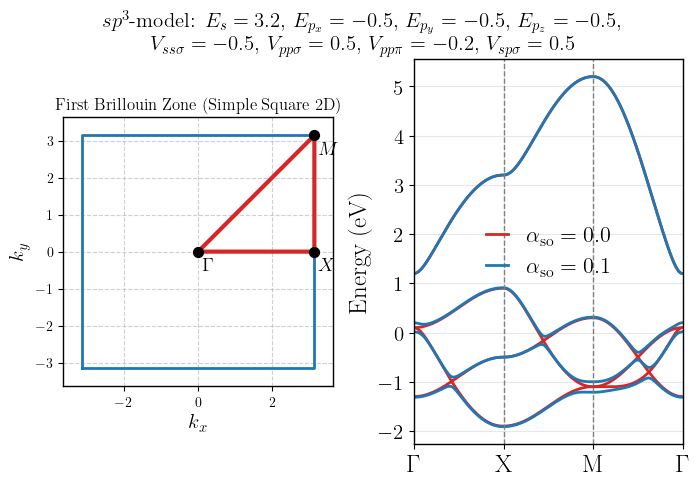

In [ ]:
def main_plot_BandStructure_Analytically():
    # 1. Adjust the figure size to fit both plots side-by-side
    fig = plt.figure(figsize=(8, 5))

    # 2. Create the gridspec
    gs_main = gridspec.GridSpec(1, 2, figure=fig, wspace=0.3)

    # 3. Create the subplots
    ax1 = fig.add_subplot(gs_main[0, 0])
    ax2 = fig.add_subplot(gs_main[0, 1])

    # 4. Call your functions (ensure BrillouinZone ends with ':' as corrected)

    plot_square_bz(ax1)
    plot_BandStructure_bands(ax2, bands, bands_soc, parameters, parameters_soc)

    title_geral = (
        parameters[0][:-1] +
        r"$E_{s} = " + str(parameters[2]) + r"$, " +
        r"$E_{p_x} = " + str(parameters[3]) + r"$, "  +
        r"$E_{p_y} = " + str(parameters[4]) + r"$, "  +
        r"$E_{p_z} = " + str(parameters[5]) + r"$, " + "\n" +
        r"$V_{ss\sigma} = " + str(parameters[6]) + r"$, " +
        r"$V_{pp\sigma} = " + str(parameters[7]) + r"$, " +
        r"$V_{pp\pi} = " + str(parameters[8]) + r"$, " +
        r"$V_{sp\sigma} = " + str(parameters[9]) + r"$"
    )

    fig.suptitle(title_geral, fontsize=15, fontweight='bold', y=0.98)

    # 5. Closing the boxes (Box Style) in a robust way
    for ax in [ax1, ax2]:
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1.0)
        ax.set_frame_on(True)

    # 6. Finalization
    # tight_layout usually works better than subplots_adjust to prevent label clipping
    plt.tight_layout()
    #plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95,
    #                      hspace=0.4, wspace=0.4)

    plt.show()
    plt.close()

if __name__ == "__main__":
    main_plot_BandStructure_Analytically()

## __I. Density of States__

### __2.1. *Exact Diagonalization of the Hamiltonian Reciprocal Space*__

#### Tight-binding modeling via Pybinding (monolayer lattice)



- Without SOC

In [ ]:
def sp3_model_square(name, sp, override_params=None):
    """
    Implementation of a simple cubic lattice using Slater-Koster.
    """
    # Get parameters
    params = _default_sp3.copy()
    if override_params:
        params.update(override_params)

    a, E_s, E_px, E_py, E_pz, V_ss_sigma, V_pp_sigma, V_pp_pi, V_sp_sigma, soc = params[name]
    V_sp_sigma = sp  # Overwrite s-p hopping with spin value
    soc = 0.0        # Overwrite Spin-orbit coupling value
    parameters = [r"$sp^3$-model:  ", a, E_s, E_px, E_py, E_pz, V_ss_sigma, V_pp_sigma, V_pp_pi, V_sp_sigma, soc]

    # Create lattice with primitive vectors
    lat = pb.Lattice(a1=[a, 0], a2=[0, a])

    # Atom position (all orbitals at the same position)
    pos = [0, 0]

    """ Add sublattices with on-site energies """
    lat.add_sublattices(
        ( "s", pos,  E_s),
        ("px", pos, E_px),
        ("py", pos, E_py),
        ("pz", pos, E_pz)
    )

    """ Hopping in x-direction ([+/-1, 0]) """
    lat.add_hoppings(
        # l=1, m=0, n=0
        ((1, 0),  "s",  "s",   V_ss_sigma),  # Ess                                     = Vss_sigma
        ((1, 0),  "s", "px",   V_sp_sigma),  # Espx  = l * Vsp_sigma                   = Vsp_sigma
        ((1, 0), "px", "px",   V_pp_sigma),  # Epxpx = l^2 * Vpp_sigma + (1-l^2)Vpp_pi = Vpp_sigma
        ((1, 0), "py", "py",      V_pp_pi),  # Epypy = m^2 * Vpp_sigma + (1-m^2)Vpp_pi = Vpp_pi
        ((1, 0), "pz", "pz",      V_pp_pi),  # Epzpz = n^2 * Vpp_sigma + (1-n^2)Vpp_pi = Vpp_pi
        # l=-1, m=0, n=0
        ((-1, 0),  "s", "px",  -V_sp_sigma),
    )

    """ Hopping in y-direction ([0, +/-1]) """
    lat.add_hoppings(
        # l=0, m=1, n=0
        ((0, 1),  "s",  "s",   V_ss_sigma),  # Ess   = Vss_sigma
        ((0, 1),  "s", "py",   V_sp_sigma),  # Espy  = m * Vsp_sigma = Vsp_sigma
        ((0, 1), "px", "px",      V_pp_pi),  # Epxpx = Vpp_pi
        ((0, 1), "py", "py",   V_pp_sigma),  # Epypy = Vpp_sigma
        ((0, 1), "pz", "pz",      V_pp_pi),  # Epzpz = Vpp_pi
        # l=0, m=-1, n=0
        (( 0,-1),  "s", "py",  -V_sp_sigma),
    )

    return lat, parameters

- With SOC

In [ ]:
def sp3_model_square_SOC(name, sp, soc, override_params=None):
    """
    Simple cubic sp3 lattice with spin-orbit coupling (SOC).
    """
    # Get parameters
    params = _default_sp3.copy()
    if override_params:
        params.update(override_params)

    a, E_s, E_px, E_py, E_pz, V_ss_sigma, V_pp_sigma, V_pp_pi, V_sp_sigma, lsoc = params[name]

    V_sp_sigma = sp  # Overwrite s-p hopping with spin value
    lsoc = soc       # Overwrite Spin-orbit coupling value
    parameters = [r"$sp^3$-model:  ", a, E_s, E_px, E_py, E_pz, V_ss_sigma, V_pp_sigma, V_pp_pi, V_sp_sigma, soc]

    # Create lattice with primitive vectors
    lat = pb.Lattice(a1=[a, 0], a2=[0, a])

    # Atom position (all orbitals at the same position)
    pos = [0, 0]

    """ Add sublattices with on-site energies """
    lat.add_sublattices(
        ( "s_up", pos,  E_s), ( "s_dn", pos,  E_s),
        ("px_up", pos, E_px), ("px_dn", pos, E_px),
        ("py_up", pos, E_py), ("py_dn", pos, E_py),
        ("pz_up", pos, E_pz), ("pz_dn", pos, E_pz)
    )

    """ Add hoppings """
    directions = [
        ([1, 0], "px"), # x
        ([0, 1], "py"), # y
    ]

    for vec, p_orb in directions:
        neg_vec = [-v for v in vec] # Vetor oposto (-1, 0) etc.

        for spin in ["up", "dn"]:
            # s-s hopping (Simétrico)
            lat.add_hoppings((vec, f"s_{spin}", f"s_{spin}", V_ss_sigma))
            # s-p hopping (O segredo: sinal inverte na direção oposta)
            # Direção positiva (+x, +y)
            lat.add_hoppings((vec, f"s_{spin}", f"{p_orb}_{spin}", V_sp_sigma))
            # Direção negativa (-x, -y)
            lat.add_hoppings((neg_vec, f"s_{spin}", f"{p_orb}_{spin}", -V_sp_sigma))
            # p-p sigma (Simétrico)
            lat.add_hoppings((vec, f"{p_orb}_{spin}", f"{p_orb}_{spin}", V_pp_sigma))
            # p-p pi (Simétrico)
            others = [o for o in ["px", "py"] if o != p_orb]
            for other_p in others:
                lat.add_hoppings((vec, f"{other_p}_{spin}", f"{other_p}_{spin}", V_pp_pi))

    """ Spin-orbital coupling ([0,0]) """
    lat.add_hoppings(
        # Lz between px and py
        ([0, 0], "px_up", "py_up", -1j * lsoc),
        ([0, 0], "px_dn", "py_dn",  1j * lsoc),
        # L+/L- between pz e px/py
        ([0, 0], "px_up", "pz_dn",       lsoc),
        ([0, 0], "px_dn", "pz_up",      -lsoc),
        ([0, 0], "py_up", "pz_dn", -1j * lsoc),
        ([0, 0], "py_dn", "pz_up", -1j * lsoc)
    )

    return lat, parameters

Model initialization and bulk symmetry application:
- __sp3_1:__ without SOC
- __sp3_2:__ with SOC

In [ ]:
sp3_1, parameters_1 = sp3_model_square("SP3-Go", sp = 0.5, override_params=None)
sp3_2, parameters_2 = sp3_model_square_SOC("SP3-Go", sp = 0.5, soc = 0.1, override_params=None)
"""
Bulk Model Creation:
    Converts the sp3u and sp3d lattices into complete models.
    Applies translational symmetry (pb.translational_symmetry()) to simulate an infinite crystal.
"""
bulk_sp3_1 = pb.Model(sp3_1, pb.translational_symmetry())
bulk_sp3_2 = pb.Model(sp3_2, pb.translational_symmetry())

#### Band structure calculations

Reciprocal space setup

In [ ]:
"""
Definition of High-Symmetry Points:
    Defines key points in the Brillouin Zone for a square lattice:
        Γ (Center)           : [0, 0]
        X (Edge midpoint)    : [π, 0]
        M (Corner)           : [π, π]
    These points are standard for band structure calculations in 2D materials.
"""
Gamma = [0, 0]
X = [np.pi, 0]
M = [np.pi, np.pi]

Band structure solver initialization (numerical diagonalization of the Hamiltonian)


In [ ]:
""" Band Structure Calculations """
step = 0.01                             # "step" determines the resolution along the k-path
solver_1 = pb.solver.lapack(bulk_sp3_1) # Uses LAPACK (robust numerical library) for diagonalization
solver_2 = pb.solver.lapack(bulk_sp3_2) # Uses LAPACK (robust numerical library) for diagonalization

Eigenvalue extraction along the high-symmetry path:

$\Gamma \to {\rm X} \to {\rm M} \to \Gamma$

In [ ]:
"""
Trace the path Γ → X → M → Γ and compute eigenvalues (energies) for each k-point
"""
bands_bulk_sp3_1 = solver_1.calc_bands(Gamma, X, M, Gamma, step=step)
bands_bulk_sp3_2 = solver_2.calc_bands(Gamma, X, M, Gamma, step=step)

# Prints the eigenvectors (wavefunctions) calculated for the bulk_sp3_1 model
#print(solver_1.eigenvectors)
#print("===============================================================================")
# Prints the eigenvectors (wavefunctions) calculated for the bulk_sp3_2 model
#print(solver_2.eigenvectors)

#### Visualization: Reciprocal space and electronic dispersion

In [ ]:
def plot_BandStructure_bands_Diagonalization(ax):
    label = r"Diagonalization"
    bands_bulk_sp3_1.plot(ax=ax, color='tab:red', lw=2, label=label)
    #---------------------------------------------------------------------------
    dists = np.sqrt(np.sum(np.diff(full_path, axis=0)**2, axis=1))
    k_dist = np.concatenate(([0], np.cumsum(dists))) # Eixo X em unidades de 1/A
    lab1 = r"Analytically"
    ax.plot(k_dist, bands[:, 0], color='black', lw=2, linestyle="--", label=lab1)
    ax.plot(k_dist, bands[:, 1], color='black', lw=2, linestyle="--")
    ax.plot(k_dist, bands[:, 2], color='black', lw=2, linestyle="--")
    ax.plot(k_dist, bands[:, 3], color='black', lw=2, linestyle="--")
    #---------------------------------------------------------------------------

    xlabel = [r"$\Gamma$", r"${\rm X}$", r"${\rm M}$", r"$\Gamma$"]
    k_path = bands_bulk_sp3_1.k_path
    k_axis = k_path.as_1d()
    indices = k_path.point_indices
    x_ticks = k_axis[indices]

    ax.set_xticks(x_ticks)
    ax.set_xticklabels(xlabel, fontsize=15)
    ax.set_xlabel("")
    ax.set_xlim(x_ticks[0], x_ticks[-1])
    ax.set_ylabel("Energy (eV)", fontsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.grid(True, alpha=0.5)

    #ax.legend(fontsize=12,frameon=False,loc='center')
    # Pegamos todos os handles (linhas) e labels (textos) do gráfico
    handles, labels = ax.get_legend_handles_labels()

    # Criamos um dicionário para remover duplicatas (mantendo a ordem)
    by_label = dict(zip(labels, handles))

    # Desenha a legenda apenas com os itens únicos
    ax.legend(by_label.values(), by_label.keys(),
            fontsize=12, frameon=False, loc='best', handlelength=1.0)

    texto = r"$\alpha_{\rm sc} = " + str(parameters_1[10]) + r"$"
    ax.text(0.5, 4.0, texto, fontsize=15, fontweight='bold')

    return ax

In [ ]:
def plot_BandStructure_bands_SOC_Diagonalization(ax):
    label = r"Diagonalization"
    bands_bulk_sp3_2.plot(ax=ax, color='tab:red', lw=2, label=label)
    #---------------------------------------------------------------------------
    dists = np.sqrt(np.sum(np.diff(full_path, axis=0)**2, axis=1))
    k_dist = np.concatenate(([0], np.cumsum(dists))) # Eixo X em unidades de 1/A
    lab1 = r"Analytically"
    ax.plot(k_dist, 0.5*bands_soc[:, 6] + 0.5*bands_soc[:, 7], color='black', lw=2, linestyle="--", label=lab1)
    ax.plot(k_dist, 0.5*bands_soc[:, 5] + 0.5*bands_soc[:, 5], color='black', lw=2, linestyle="--")
    ax.plot(k_dist, 0.5*bands_soc[:, 2] + 0.5*bands_soc[:, 3], color='black', lw=2, linestyle="--")
    ax.plot(k_dist, 0.5*bands_soc[:, 0] + 0.5*bands_soc[:, 1], color='black', lw=2, linestyle="--")
    #---------------------------------------------------------------------------
    xlabel = [r"$\Gamma$", r"${\rm X}$", r"${\rm M}$", r"$\Gamma$"]
    k_path = bands_bulk_sp3_2.k_path
    k_axis = k_path.as_1d()
    indices = k_path.point_indices
    x_ticks = k_axis[indices]

    ax.set_xticks(x_ticks)
    ax.set_xticklabels(xlabel, fontsize=15)
    ax.set_xlabel("")
    ax.set_xlim(x_ticks[0], x_ticks[-1])
    ax.set_ylabel("", fontsize=15)
    ax.tick_params(axis='both', labelsize=15) # Aplica a ambos os eixos
    ax.grid(True, alpha=0.5)

    #ax.legend(fontsize=12,frameon=False,loc='center')
    # Pegamos todos os handles (linhas) e labels (textos) do gráfico
    handles, labels = ax.get_legend_handles_labels()

    # Criamos um dicionário para remover duplicatas (mantendo a ordem)
    by_label = dict(zip(labels, handles))

    # Desenha a legenda apenas com os itens únicos
    ax.legend(by_label.values(), by_label.keys(),
            fontsize=12, frameon=False, loc='best', handlelength=1.0)

    texto = r"$\alpha_{\rm sc} = " + str(parameters_soc[10]) + r"$"
    ax.text(0.5, 4.0, texto, fontsize=15, fontweight='bold')

    return ax

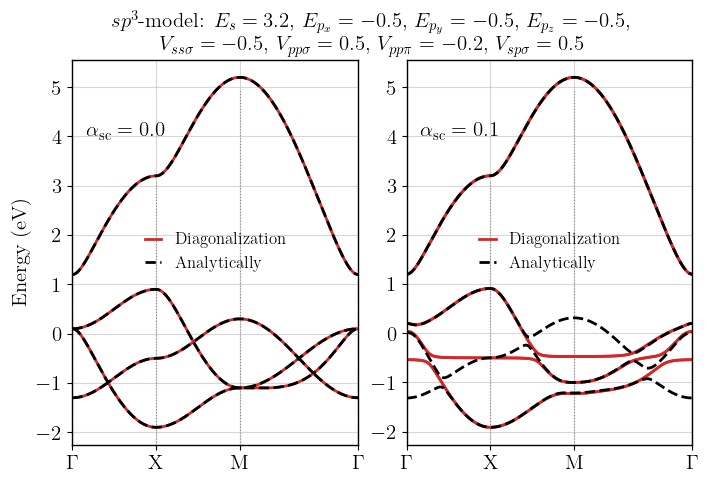

In [ ]:
def main_plot_BandStructure_Diagonalization():
    # 1. Adjust the figure size to fit both plots side-by-side
    fig = plt.figure(figsize=(8, 5))

    # 2. Create the gridspec
    gs_main = gridspec.GridSpec(1, 2, figure=fig, wspace=0.17)

    # 3. Create the subplots
    ax1 = fig.add_subplot(gs_main[0, 0])
    ax2 = fig.add_subplot(gs_main[0, 1])

    # 4. Call your functions (ensure BrillouinZone ends with ':' as corrected)
    plot_BandStructure_bands_Diagonalization(ax1)
    plot_BandStructure_bands_SOC_Diagonalization(ax2)

    title_geral = (
        parameters_1[0][:-1] +
        r"$E_{s} = " + str(parameters_1[2]) + r"$, " +
        r"$E_{p_x} = " + str(parameters_1[3]) + r"$, " +
        r"$E_{p_y} = " + str(parameters_1[4]) + r"$, " +
        r"$E_{p_z} = " + str(parameters_1[5]) + r"$, " + "\n" +
        r"$V_{ss\sigma} = " + str(parameters_1[6]) + r"$, " +
        r"$V_{pp\sigma} = " + str(parameters_1[7]) + r"$, " +
        r"$V_{pp\pi} = " + str(parameters_1[8]) + r"$, " +
        r"$V_{sp\sigma} = " + str(parameters_1[9]) + r"$"
    )

    fig.suptitle(title_geral, fontsize=15, fontweight='bold', y=0.98)

    # 5. Closing the boxes (Box Style) in a robust way
    for ax in [ax1, ax2]:
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1.0) # Makes the border slightly sharper/cleaner
        ax.set_frame_on(True)

    # 6. Finalization
    # tight_layout usually works better than subplots_adjust to prevent label clipping
    plt.tight_layout()
    #plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95,
    #                      hspace=0.4, wspace=0.4)

    plt.show()
    plt.close()

if __name__ == "__main__":
    main_plot_BandStructure_Diagonalization()